# Finding the possible symmetries for the regularized shapes

Features shape for Screenshot 2024-08-11 230705.png: (7,)


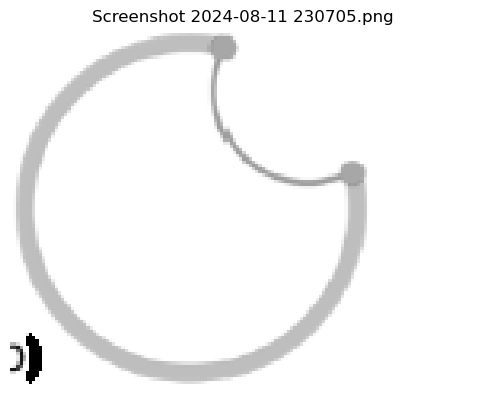

Image: Screenshot 2024-08-11 230705.png - Predicted Shape: circle


In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours of the empty portions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is the empty portion
    if contours:
        empty_contour = max(contours, key=cv2.contourArea)
        return empty_contour, image
    return None, image

def extract_features(contour):
    if contour is None or len(contour) == 0:
        return np.zeros(7)  # Placeholder for feature vector, adjust size as needed
    
    # Calculate shape features
    moments = cv2.moments(contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Example feature vector
    features = np.concatenate([hu_moments])
    return features

def classify_shape(features, model):
    if features.size == 0:
        raise ValueError("Feature vector is empty.")
    
    # Ensure the features are 2D for prediction (reshape to 1 row, multiple columns)
    features = features.reshape(1, -1)
    return model.predict(features)[0]

def train_shape_classifier(training_data, training_labels):

    scaler = StandardScaler()
    classifier = SVC(kernel='linear')
    
    pipeline = make_pipeline(scaler, classifier)
    pipeline.fit(training_data, training_labels)
    return pipeline

def plot_image_with_contour(image, contour, filename):
    if contour is not None:
        # Draw contour on the image
        contour_image = cv2.drawContours(image.copy(), [contour], -1, (0, 255, 0), 2)
    else:
        contour_image = image.copy()
    
    plt.figure(figsize=(6, 6))
    plt.imshow(contour_image, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    plt.show()

def process_images_in_directory(directory_path, model):
    shape_predictions = {}
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.png'):
            image_path = os.path.join(directory_path, filename)
            
            # Preprocess the image to extract the empty portion
            contour, image = preprocess_image(image_path)
            
            # Extract features from the contour
            features = extract_features(contour)
            
            # Print feature shape for debugging
            print(f"Features shape for {filename}: {features.shape}")
            
            # Check if features are empty or not before classification
            if features.size == 0:
                shape_predictions[filename] = "Unknown"
            else:
                try:
                    # Classify the shape
                    shape = classify_shape(features, model)
                    shape_predictions[filename] = shape
                except ValueError as e:
                    print(f"Error classifying image {filename}: {e}")
                    shape_predictions[filename] = "Unknown"
            
            # Plot the image with detected contour
            plot_image_with_contour(image, contour, filename)
    
    return shape_predictions

training_data = np.array([

    np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),  # Feature vector for shape 1
    np.array([0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]),  # Feature vector for shape 2

])
training_labels = np.array([
    
    'circle',  
    'square',  
   
])

# Train the shape classifier
model = train_shape_classifier(training_data, training_labels)

# Process images and classify shapes
directory_path = 'C:\\Users\\LENOVO\\OneDrive\\Desktop\\ashxva'
shape_predictions = process_images_in_directory(directory_path, model)

for image, shape in shape_predictions.items():
    print(f"Image: {image} - Predicted Shape: {shape}")
